## 8. K-Nearest Neighbor (KNN)

In [ ]:
!pip install pyod
!pip install combo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193258 sha256=6b36edd950ba53c92c76d976e4282ad8192a188cd9aacd69743ac566441d708e
  Stored in directory: /root/.cache/pip/wheels/94/75/88/b853cf33b0053b0a001dca55b74d515048b7656e736364eb57
Successfully built pyod
  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42856 sha256=bf7559af087174b5ac3bfe2f88179bece49b3ae006e1d5c4319d21cc53857879
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


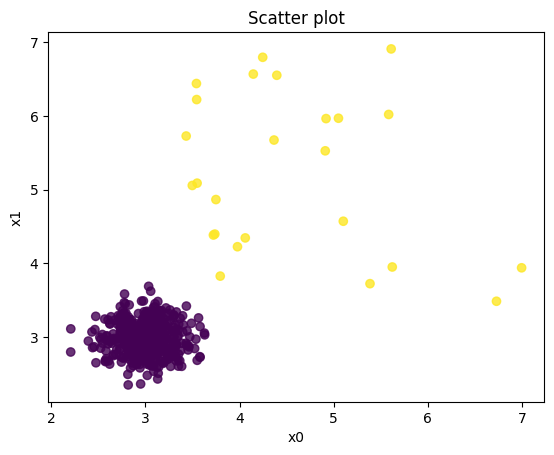

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features= n_features,
    contamination=contamination,
    random_state=123)

X_train = 5 - X_train
X_test = 5 - X_test
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)
X_train_pd.head()

# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [ ]:
##################################
# User-defined utility functions #
##################################

def count_stat(vector):
    # Because it is '0' and '1',
    # we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df.columns = feature_list
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

def confusion_matrix_threshold(
    actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def confusion_matrix(actual,pred):
    Actual_pred = pd.DataFrame({'Actual': actual,'Pred': pred})
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def plot_data():
    plt.scatter(X_train_pd[0], X_train_pd[1],c=y_train, alpha=0.8)
    plt.title('Scatter plot')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

### Step 1: Build the model

In [ ]:
# train kNN detector
from pyod.models.knn import KNN
knn = KNN()
knn.fit(X_train)
# If you want to see the predictions of the training data, you can use this way:
y_train_scores = knn.decision_scores_

In [ ]:
from pyod.models.knn import KNN
knn = KNN(contamination=0.05)
knn.fit(X_train)

# Training data
y_train_scores = knn.decision_function(X_train)
y_train_pred = knn.predict(X_train)

# Test data
y_test_scores = knn.decision_function(X_test)
y_test_pred = knn.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , knn.threshold_)

The training data: {0: 475, 1: 25}
The training data: {0: 475, 1: 25}
The threshold for the defined contamination rate: 0.75661276565155


In [ ]:
knn.get_params()

{'algorithm': 'auto',
 'contamination': 0.05,
 'leaf_size': 30,
 'method': 'largest',
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'radius': 1.0}

### Step 2: Determine the threshold

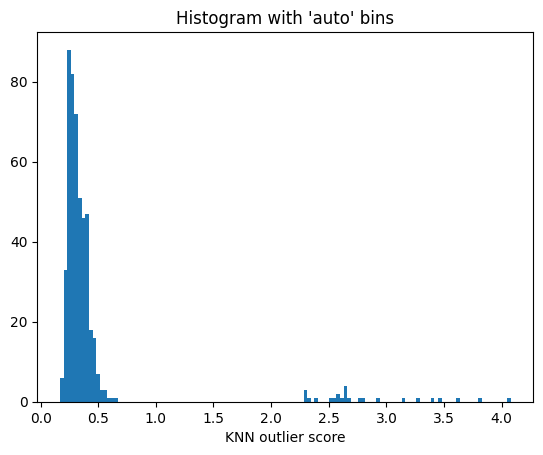

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('KNN outlier score')
plt.show()

### Step 3: Descriptive statistics

In [ ]:
threshold = knn.threshold_ # Or other value from the above histogram
feature_list = ['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6']
descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,3.00,2.99,2.99,3.01,2.99,3.02,0.32
1,Outlier,25,5.0,4.55,5.21,5.47,5.23,5.03,5.06,2.84


In [ ]:
confusion_matrix_threshold(y_train, y_train_scores, knn.threshold_)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


In [ ]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


### Averages

In [ ]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

# Test a range of k-neighbors from 10 to 200.
# There will be 20 k-NN models.
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,
 120, 130, 140, 150, 160, 170, 180, 190, 200]
n_clf = len(k_list)

# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape

# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_function(X_train)
    test_scores[:, i] = clf.decision_function(X_test)

# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

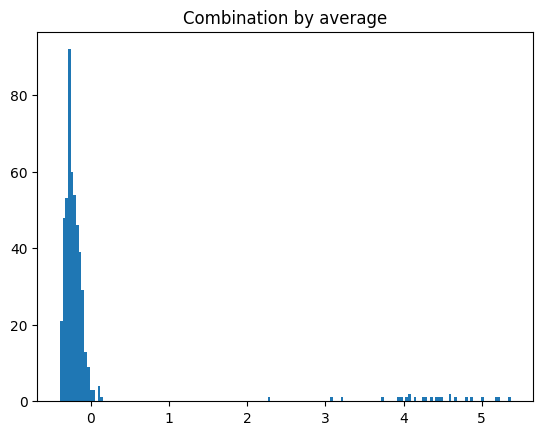

In [ ]:
# Combination by average
# The test_scores_norm is 500 x 10.
# The "average" function will take the average of the 10 columns.
# The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto')
plt.title("Combination by average")
plt.show()

In [ ]:
descriptive_stat_threshold(X_train,y_train_by_average, 1)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,3.00,2.99,2.99,3.01,2.99,3.02,-0.23
1,Outlier,25,5.0,4.55,5.21,5.47,5.23,5.03,5.06,4.28


In [ ]:
descriptive_stat_threshold(X_test,y_test_by_average, 0.5)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,2.98,2.99,2.99,3.01,2.99,3.00,-0.23
1,Outlier,25,5.0,5.00,5.54,5.23,5.05,5.06,4.88,4.31


### Appendix

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
samples = X_train[0:5]
samples

array([[2.60390984, 2.90738884, 2.92660766, 3.01173839, 3.04652749,
        2.54900258],
       [3.36895987, 3.25381841, 3.10195002, 2.61985227, 3.03266763,
        3.14108355],
       [3.17531653, 2.86858758, 2.97117089, 3.29654615, 2.49703445,
        2.88089237],
       [2.89390217, 2.83482701, 2.65917375, 2.82989053, 3.25086109,
        3.32133918],
       [3.17035344, 3.22440352, 3.17056246, 2.94523197, 3.42280969,
        3.40545136]])

In [ ]:
my_knn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(samples)
distances, indices    = my_knn.kneighbors(samples,
      return_distance=True)
distances

array([[0.        , 0.90730696],
       [0.        , 0.61072952],
       [0.        , 0.90730696],
       [0.        , 0.73461446],
       [0.        , 0.61072952]])

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 1, 0, 1, 1], dtype=int32)

In [ ]:
centroids = kmeans.cluster_centers_
centroids


array([[2.88961319, 2.88798821, 2.94888927, 3.15414227, 2.77178097,
        2.71494748],
       [3.14440516, 3.10434965, 2.97722874, 2.79832492, 3.23544614,
        3.28929136]])